In [1]:
# libraries
using Flux             # the julia ml library
using Images           # image processing and machine vision for julia
using MLJ              # make_blobs, rmse, confmat, categorical
using MLDataUtils      # label, nlabel, labelfreq
using MLDatasets       # mnist

using MLJLinearModels

using LinearAlgebra    # pinv pseudo-inverse matrix
using Metrics          # r2-score
using Random
using StatsBase        # standardize (normalization)
using Distributions

using Plots; gr()
using StatsPlots
using Printf

using CSV
using DataFrames


,,,,

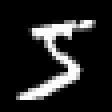
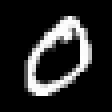
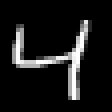
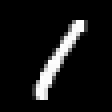
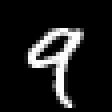

1×5 adjoint(::Vector{Int64}) with eltype Int64:
 5  0  4  1  9

In [2]:
# load mnist from MLDatasets
trainX_original,      trainY_original      = MNIST.traindata()
validationX_original, validationY_original = MNIST.testdata();

display([MNIST.convert2image(MNIST.traintensor(i)) for i in 1:5])
trainY_original[1:5]'

In [3]:
# trainset, testset, validation set
Random.seed!(1)
(trainX, trainY), (testX, testY) = stratifiedobs((trainX_original, trainY_original), p = 0.7)
validationX = copy(validationX_original); validationY = copy(validationY_original)

size(trainX), size(testX), size(validationX)

((28, 28, 42001), (28, 28, 17999), (28, 28, 10000))

In [4]:
# functions for feature extraction
meanIntensity(img) = mean(Float64.(img))

function hSymmetry(img)
    imgFloat = Float64.(img)
    imgReverse = reverse(imgFloat, dims=1)
    return -mean( abs.(imgFloat - imgReverse) )
end

hSymmetry (generic function with 1 method)

In [5]:
h, v, N = size(trainX)
a = [meanIntensity( trainX[:, :, i] ) for i in 1:N]
b = [hSymmetry( trainX[:, :, i] )     for i in 1:N]
trainX = hcat(a, b)
display(size(trainX))


(42001, 2)

In [6]:
# rescale predictors
function rescaleByColumns(X)
    # using StatsBase
    X = Float64.(X)
    dt = StatsBase.fit(ZScoreTransform, X; dims=1, center=true, scale=true)
    rescaledX = StatsBase.transform(dt, X)
end

trainX = rescaleByColumns(trainX)
mean(trainX, dims=1)

1×2 Matrix{Float64}:
 -4.09398e-16  -1.79112e-16

In [7]:
# select two classes
P = 5   # positive class
N = 1   # negative class

# data selection from above classes and sizes
trainX = vcat( trainX[trainY .== P, :], trainX[trainY .== N, :] )
trainY = vcat( trainY[trainY .== P],    trainY[trainY .== N] )
levels(trainY)

2-element Vector{Int64}:
 1
 5

In [8]:
# specific conversions for MLJ
trainX = DataFrame(trainX, :auto)
trainY = categorical(trainY, ordered=true);

In [9]:
#@load LogisticClassifier pkg=MLJLinearModels
mdl = LogisticClassifier()
mach = machine(mdl, trainX, trainY)
fit!(mach)

┌ Info: Training Machine{LogisticClassifier,…}.
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/CglMw/src/machines.jl:464


Machine{LogisticClassifier,…} trained 1 time; caches data
  model: LogisticClassifier
  args: 
    1:	Source @635 ⏎ `Table{AbstractVector{ScientificTypesBase.Continuous}}`
    2:	Source @023 ⏎ `AbstractVector{OrderedFactor{2}}`


In [10]:
params = fitted_params(mach)
p = MLJ.predict(mach, trainX)
p[1:5]

5-element CategoricalDistributions.UnivariateFiniteArray{OrderedFactor{2}, Int64, UInt32, Float64, 1}:
 UnivariateFinite{OrderedFactor{2}}(1=>0.489, 5=>0.511)
 UnivariateFinite{OrderedFactor{2}}(1=>0.533, 5=>0.467)
 UnivariateFinite{OrderedFactor{2}}(1=>0.572, 5=>0.428)
 UnivariateFinite{OrderedFactor{2}}(1=>0.606, 5=>0.394)
 UnivariateFinite{OrderedFactor{2}}(1=>0.443, 5=>0.557)

In [11]:
p[1]

         UnivariateFinite{OrderedFactor{2}}     
     ┌                                        ┐ 
   1 ┤■■■■■■■■■■■■■■■■■■■ 0.48909999811476434   
   5 ┤■■■■■■■■■■■■■■■■■■■■ 0.5109000018852357   
     └                                        ┘ 

In [12]:
ŷ = predict_mode(mach)
ŷ[1:5]

5-element CategoricalArrays.CategoricalArray{Int64,1,UInt32}:
 5
 1
 1
 1
 5

In [13]:
confmat(ŷ, trainY)

              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      5      │
├─────────────┼─────────────┼─────────────┤
│      1      │    4421     │    1684     │
├─────────────┼─────────────┼─────────────┤
│      5      │     298     │    2111     │
└─────────────┴─────────────┴─────────────┘
